In [ ]:


!pip install pandas matplotlib wordcloud scikit-learn nltk tqdm beautifulsoup4


In [ ]:
import os
import email
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import google.generativeai as genai
from sklearn.ensemble import IsolationForest
from wordcloud import WordCloud, STOPWORDS
import nltk
from tqdm import tqdm
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define source and destination paths
source_path = "/content/drive/My Drive/EnronDataset/maildir/maildir_backup.zip"
destination_path = "/content/maildir_backup.zip"

# Copy file from Google Drive
!cp "{source_path}" "{destination_path}"

# Check if the file exists after copying
if os.path.exists(destination_path):
    print(" File copied successful ly! Ready for extraction.")
else:
    print(" File copy failed. Please check the file path.")


 File copied successful ly! Ready for extraction.


In [ ]:
!ls -lh /content/maildir_backup.zip


-rw------- 1 root root 684M Feb 22 07:21 /content/maildir_backup.zip


In [ ]:
import zipfile

# Define paths
zip_path = "/content/maildir_backup.zip"
extract_path = "/content/maildir"

# Extract ZIP file
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Dataset extracted successfully!")

    # Verify extraction by listing top-level directories
    extracted_folders = os.listdir(extract_path)
    if len(extracted_folders) > 0:
        print(f"📂 Extracted {len(extracted_folders)} folders inside maildir.")
        print("Sample folders:", extracted_folders[:10])  # Show first 10 folders
    else:
        print("⚠️ Extraction completed, but no folders were found!")

except zipfile.BadZipFile:
    print("❌ Error: Corrupt ZIP file. Please re-upload.")
except FileNotFoundError:
    print("❌ Error: ZIP file not found. Ensure it's correctly copied from Google Drive.")


✅ Dataset extracted successfully!
📂 Extracted 1 folders inside maildir.
Sample folders: ['maildir']


In [ ]:
!ls -l /content/maildir | head -20


total 4
drwxr-xr-x 152 root root 4096 Feb 22 06:20 maildir


In [ ]:
!find /content/maildir -type f | wc -l


517401


In [ ]:
import email
import pandas as pd
from tqdm import tqdm

# Function to load emails into a structured DataFrame
def load_enron_emails(dataset_path, max_emails=10000):
    emails = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith("."):  # Ensure we're reading only email files
                try:
                    with open(os.path.join(root, file), "r", encoding="latin-1") as f:
                        content = f.read()
                        e = email.message_from_string(content)
                        emails.append({
                            "Message-ID": e.get("Message-ID"),
                            "Date": e.get("Date"),
                            "From": e.get("From"),
                            "To": e.get("To"),
                            "Subject": e.get("Subject"),
                            "Body": e.get_payload()
                        })
                except Exception:
                    pass
            if len(emails) >= max_emails:  # Limit dataset for performance
                break
    return pd.DataFrame(emails)

# Load dataset (limiting to 10,000 emails for performance)
df = load_enron_emails("/content/maildir", max_emails=10000)

# Fix Date Parsing Issue
df["Date"] = pd.to_datetime(df["Date"], errors="coerce", utc=True)

# Drop rows with missing data
df = df.dropna()

# Display the cleaned dataset (first 5 rows)
df.head(100)


<ipython-input-9-1188443bce14>:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce", utc=True)


,Message-ID,Date,From,To,Subject,Body
0,<6433257.1075842455323.JavaMail.evans@thyme>,2000-02-07 16:43:00+00:00,drew.fossum@enron.com,martha.benner@enron.com,Re: Conference call number for Cunningham Elec...,pls print for my wed. mtg. thanks. df\n------...
1,<1463300.1075842546778.JavaMail.evans@thyme>,2001-04-03 16:47:00+00:00,drew.fossum@enron.com,emily.sellers@enron.com,"FW: CONFIRMATION: April 20, 2001 Executive For...",---------------------- Forwarded by Drew Fossu...
2,<19805440.1075842545180.JavaMail.evans@thyme>,2001-02-16 11:20:00+00:00,drew.fossum@enron.com,dloon@uschamber.com,DC,What the hell is going on with you??? I'm bor...
3,<14315818.1075842462814.JavaMail.evans@thyme>,2000-10-27 23:15:00+00:00,enron.announcements@enron.com,all.worldwide@enron.com,"eThink About It: October 31, 2000",ThinkBank went live with a bang last Friday! ...
4,<16647528.1075842543495.JavaMail.evans@thyme>,2000-12-19 09:38:00+00:00,drew.fossum@enron.com,danny.mccarty@enron.com,Returned mail: Host unknown (Name server: enro...,"Danny, I'm resending as I had the same problem..."
...,...,...,...,...,...,...
98,<32692480.1075842464770.JavaMail.evans@thyme>,2000-11-02 18:53:00+00:00,enron.announcements@enron.com,all.worldwide@enron.com,"Japan, India and California, too?",Enron opens an office in Japan. Get the detai...
99,<17867643.1075842477555.JavaMail.evans@thyme>,2000-12-11 16:26:00+00:00,michael.moran@enron.com,dorothy.mccoppin@enron.com,Re: ETS STAFF MEETING - Jan. 2,9am is fine.
100,<12778380.1075842460009.JavaMail.evans@thyme>,2000-08-07 10:46:00+00:00,martha.benner@enron.com,"breasoner@gibbs-bruns.com, csweetland@gibbs-br...",,"In case you haven't done it already, please cr..."
101,<29580209.1075842545506.JavaMail.evans@thyme>,2001-03-06 13:21:00+00:00,drew.fossum@enron.com,dloon@uschamber.com,,Acapulco. You guys are weak. I take my wife ...


In [ ]:
import pandas as pd

# Count of Emails Sent by Each Sender
sender_counts = df["From"].value_counts()

# Count of Emails Received by Each Recipient
df["To"] = df["To"].astype(str)  # Ensure all values are strings
all_recipients = df["To"].str.split(",").explode()  # Split multiple recipients
recipient_counts = all_recipients.value_counts()

# Identify External Emails (Not @enron.com)
df["External_Sender"] = ~df["From"].str.contains("@enron.com", na=False)
df["External_Recipient"] = ~df["To"].str.contains("@enron.com", na=False)

# Count Unique External Senders & Recipients
unique_external_senders = df[df["External_Sender"]]["From"].nunique()
unique_external_recipients = df[df["External_Recipient"]]["To"].nunique()

# Display Insights
print(f"✅ Total Unique External Senders: {unique_external_senders}")
print(f"✅ Total Unique External Recipients: {unique_external_recipients}")

# Show Top 400 Recipients
top_400_recipients = recipient_counts.head(400)

# Show Top 400 Senders
top_400_senders = sender_counts.head(400)

# Display as DataFrames
print("\n📌 **Top 10 Recipients**")
print(top_400_recipients.head(10))

print("\n📌 **Top 10 Senders**")
print(top_400_senders.head(10))

# Save results to CSV for easy download
top_400_recipients.to_csv("/content/Top_400_Recipients.csv")
top_400_senders.to_csv("/content/Top_400_Senders.csv")

print("\n✅ CSV files saved: 'Top_400_Recipients.csv' and 'Top_400_Senders.csv'")


✅ Total Unique External Senders: 564
✅ Total Unique External Recipients: 345

📌 **Top 10 Recipients**
To
gabriel.monroy@enron.com    742
martha.benner@enron.com     658
john.lavorato@enron.com     372
susan.scott@enron.com       335
kori.loibl@enron.com        287
 drew.fossum@enron.com      252
drew.fossum@enron.com       225
 mary.miller@enron.com      215
becky.pitre@enron.com       184
 susan.scott@enron.com      180
Name: count, dtype: int64

📌 **Top 10 Senders**
From
drew.fossum@enron.com            3575
robin.rodrigue@enron.com         2477
john.lavorato@enron.com          1076
stacy.dickson@enron.com           378
enron.announcements@enron.com     102
lorna.brennan@enron.com            83
kathy.reeves@enron.com             75
c.griffin@enron.com                75
kimberly.hillis@enron.com          69
susan.scott@enron.com              64
Name: count, dtype: int64

✅ CSV files saved: 'Top_400_Recipients.csv' and 'Top_400_Senders.csv'


In [ ]:
# Find the most common email subjects (Top 20)
subject_counts = df["Subject"].value_counts().head(20)

print("\n📌 **Most Common Email Subjects:**")
print(subject_counts)



📌 **Most Common Email Subjects:**
Subject
                                              835
Re:                                           343
VAR                                           184
Pueblo                                         91
EES Volumetric Positions                       75
Re: FW: Organization Announcement              52
Re: Pueblo                                     34
RE:                                            33
PS                                             31
Re: Organization Announcement                  28
Re: PS                                         27
Re: Citizens request for proposal              25
Re: Hey                                        24
CCT VAR                                        24
Re: Lunch                                      24
Re: TW                                         22
FW:                                            22
Re: Transwestern Contract Approval Request     21
CCT                                            20
Re: FER

In [ ]:
from sklearn.ensemble import IsolationForest

# Feature Engineering: Extract email lengths and hour of sending
df["Body_Length"] = df["Body"].str.len()
df["Hour"] = df["Date"].dt.hour

# Train Isolation Forest Model for Anomaly Detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df["Anomaly_Score"] = iso_forest.fit_predict(df[["Body_Length", "Hour"]])

# Show the number of detected anomalies
anomalies_count = (df["Anomaly_Score"] == -1).sum()
print(f"🚨 Detected {anomalies_count} potential anomalies.")


🚨 Detected 127 potential anomalies.


In [ ]:
import re
from bs4 import BeautifulSoup
from bs4 import MarkupResemblesLocatorWarning
import warnings

# Suppress BeautifulSoup warnings about URL-like text
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)


In [ ]:
# Dictionary to replace common obfuscated words with their correct form
obfuscation_replacements = {
    "cl1ck": "click", "fr33": "free", "m0ney": "money", "pr1ze": "prize",
    "cred1t": "credit", "l0gin": "login", "v3rify": "verify", "act n0w": "act now",
    "suspici0us": "suspicious", "€": "e", "@": "a", "0": "o", "1": "i", "3": "e", "5": "s"
}


In [ ]:
obfuscation_patterns = [
    r"[^a-zA-Z\s]",  # Special characters (e.g., $, @, !, %, etc.)
    r"\b\w+\d+\w*\b",  # Words mixed with numbers (e.g., "Fr33", "M0ney")
    r"\b\w+[-_]+\w*\b",  # Words with special characters in between (e.g., "F_R_E_E")
    r"&#\d+;",  # HTML character encoding
    r"<font color=['\"]?white['\"]?>.*?</font>",  # Hidden text in white font
]


In [ ]:
def normalize_obfuscation(text):
    """Replaces obfuscated words with their correct form."""
    if not text:
        return ""

    text = text.lower()
    for obf, normal in obfuscation_replacements.items():
        text = text.replace(obf, normal)
    return text


In [ ]:
def detect_obfuscation(text):
    """Checks if an email contains obfuscation techniques and calculates obfuscation percentage."""
    if not text:
        return 0  # No obfuscation if text is empty

    normalized_text = normalize_obfuscation(text)
    total_words = len(normalized_text.split())
    obfuscated_words = 0

    # Check for common obfuscation patterns
    for pattern in obfuscation_patterns:
        matches = re.findall(pattern, normalized_text)
        obfuscated_words += len(matches)

    # Detect hidden text (e.g., white font HTML)
    soup = BeautifulSoup(text, "html.parser")
    if soup.find_all(style=re.compile("color:\s*white", re.IGNORECASE)):
        obfuscated_words += 1  # Count hidden text as one obfuscation instance

    # Calculate obfuscation percentage
    if total_words > 0:
        obfuscation_percentage = (obfuscated_words / total_words) * 100
    else:
        obfuscation_percentage = 0

    return obfuscation_percentage  # Returns a percentage value


In [ ]:
def clean_text(text):
    """Removes obfuscation and cleans email content."""
    if not text:
        return ""

    # Normalize obfuscation first
    text = normalize_obfuscation(text)

    # Remove special characters except spaces and letters
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Remove numbers inside words (e.g., "Fr33" → "Free")
    text = re.sub(r"\b\w*\d\w*\b", "", text)

    # Use BeautifulSoup to remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    for tag in soup.find_all(style=re.compile("color:\s*white", re.IGNORECASE)):
        tag.decompose()

    return soup.get_text().strip()


In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define the path to `spam_keywords.txt` inside Google Drive
spam_keywords_path = "/content/drive/My Drive/EnronDataset/maildir/spam_keywords.txt"

def load_spam_keywords(filepath=spam_keywords_path):
    """Loads spam keywords from a file instead of hardcoding."""
    try:
        with open(filepath, "r", encoding="utf-8") as file:
            keywords = [line.strip().lower() for line in file if line.strip()]
        return keywords
    except FileNotFoundError:
        print(f"⚠️ Error: {filepath} not found. Ensure the file is correctly placed in Google Drive.")
        return []  # Return an empty list if the file is missing

# 📌 Step 4: Retrieve and Display Spam Keywords from Google Drive
spam_keywords = load_spam_keywords()

if spam_keywords:
    print(f"✅ Loaded {len(spam_keywords)} spam-related keywords.")
    print("📌 Sample Keywords:", spam_keywords[:10])  # Show first 10 keywords for verification
else:
    print("⚠️ No spam keywords loaded. Check if the file exists in Google Drive.")





✅ Loaded 50 spam-related keywords.
📌 Sample Keywords: ['free', 'win', 'offer', 'money', 'cash', 'lottery', 'prize', 'discount', 'urgent', 'click']


In [ ]:
def classify_spam(subject, body, sender_email):
    """Classifies an email as Spam if it contains spam keywords or excessive obfuscation."""
    subject_lower = str(subject).lower() if subject else ""
    body_lower = str(body).lower() if body else ""

    # Calculate obfuscation percentage
    obfuscation_percentage = detect_obfuscation(subject_lower) or detect_obfuscation(body_lower)

    # Check for spam keywords in subject or body
    contains_spam_keywords = any(word in subject_lower for word in spam_keywords) or \
                             any(word in body_lower for word in spam_keywords)

    # **Updated Condition 1**: If email has spam keywords OR obfuscation > 25%, classify as Spam
    if contains_spam_keywords or (obfuscation_percentage > 25 and not sender_email.endswith("@enron.com")):
        return "Spam"

    return "Ham"

  # Ensure spam classification is applied
df["Label"] = df.apply(lambda x: classify_spam(x["Subject"], x["Body"], x["From"]), axis=1)

# Encode labels (Spam = 1, Ham = 0)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Label"])


In [ ]:
# Ensure `df` exists before applying transformations
if "Body" in df.columns:
    df["Obfuscated"] = df["Body"].apply(detect_obfuscation)  # Detect if email is obfuscated
    df["Cleaned_Body"] = df["Body"].apply(clean_text)  # Clean text from obfuscation
else:
    print("⚠️ Error: 'Body' column not found in the dataset. Ensure the dataset is loaded properly.")


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Optimized TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=7000,
    stop_words="english",
    ngram_range=(1, 3),
    sublinear_tf=True,
    norm='l2',
    use_idf=True,
    smooth_idf=True
)



# Convert cleaned email bodies into numerical features
X = vectorizer.fit_transform(df["Cleaned_Body"])  # Use cleaned text instead of raw text


In [ ]:
# 📌 Step 1: Ensure Required Columns Exist Before Displaying
required_columns = ["Cleaned_Body", "Obfuscated", "Label"]

# Check if all required columns exist
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"⚠️ Error: Missing columns - {missing_columns}. Ensure preprocessing is applied before displaying.")
else:
    # 📌 Step 2: Show Top 5 Rows of Cleaned Text, Obfuscation Detection, and Classification
    print("\n📌 **Top 5 Rows of Cleaned Email Data Before Train-Test Split:**\n")
    print(df[["Cleaned_Body", "Obfuscated", "Label"]].head(5))



📌 **Top 5 Rows of Cleaned Email Data Before Train-Test Split:**

                                        Cleaned_Body  Obfuscated Label
0  pls print for my wed mtg  thanks df\n forwarde...  165.384615   Ham
1  forwarded by drew fossumetsenron on ooeooi \no...  117.391304  Spam
2  what the hell is going on with you  im bored a...   28.301887   Ham
3  thinkbank went live with a bang last friday  t...   23.728814  Spam
4  danny im resending as i had the same problem c...   86.029412  Spam


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Train-test split using cleaned text
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


models = {
    "NaiveBayes": MultinomialNB(),
    "RidgeClassifier": RidgeClassifier(),
    "SGDClassifier": SGDClassifier(max_iter=1000, tol=1e-3),  # Fast linear classifier
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "LinearSVC": LinearSVC()
}

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=HistGradientBoostingClassifier()
)

# Train and evaluate models
model_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_scores[name] = accuracy
    print(f"✅ {name} Accuracy: {accuracy:.4f}")

# Train and evaluate Stacking Classifier
stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
model_scores["Stacking"] = stacking_accuracy
print(f"🚀 Stacking Classifier Accuracy: {stacking_accuracy:.4f}")


✅ NaiveBayes Accuracy: 0.8216
✅ RidgeClassifier Accuracy: 0.9351
✅ SGDClassifier Accuracy: 0.9385
✅ RandomForest Accuracy: 0.9528
✅ LinearSVC Accuracy: 0.9417
🚀 Stacking Classifier Accuracy: 0.9520


In [ ]:
from sklearn.metrics import classification_report

# Evaluate Naive Bayes
y_pred_nb = models["NaiveBayes"].predict(X_test)
report_nb = classification_report(y_test, y_pred_nb, target_names=["Ham", "Spam"])
print(f"📊 NaiveBayes Classification Report:\n", report_nb)


📊 NaiveBayes Classification Report:
               precision    recall  f1-score   support

         Ham       0.83      0.88      0.86      2311
        Spam       0.80      0.72      0.76      1479

    accuracy                           0.82      3790
   macro avg       0.82      0.80      0.81      3790
weighted avg       0.82      0.82      0.82      3790



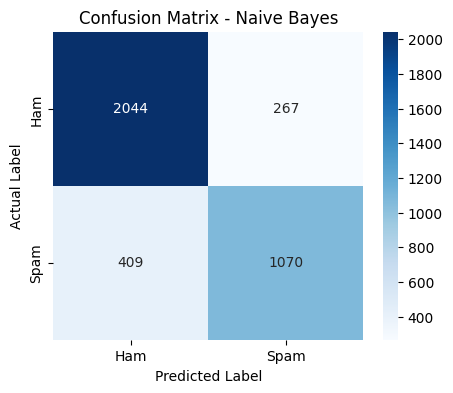

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Evaluate Ridge Classifier
y_pred_ridge = models["RidgeClassifier"].predict(X_test)
report_ridge = classification_report(y_test, y_pred_ridge, target_names=["Ham", "Spam"])
print(f"📊 RidgeClassifier Classification Report:\n", report_ridge)


📊 RidgeClassifier Classification Report:
               precision    recall  f1-score   support

         Ham       0.93      0.96      0.95      2311
        Spam       0.94      0.89      0.91      1479

    accuracy                           0.94      3790
   macro avg       0.94      0.93      0.93      3790
weighted avg       0.94      0.94      0.93      3790



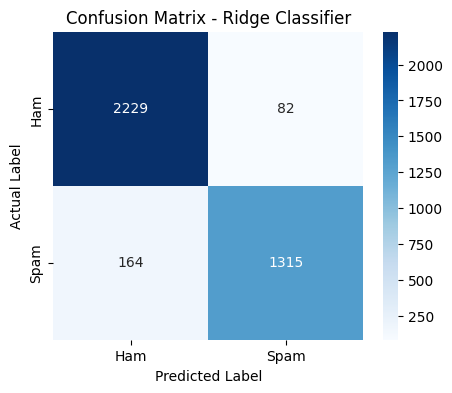

In [ ]:
# Predict using Ridge Classifier
y_pred_ridge = models["RidgeClassifier"].predict(X_test)

# Generate Confusion Matrix for Ridge Classifier
cm_ridge = confusion_matrix(y_test, y_pred_ridge)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_ridge, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Ridge Classifier")
plt.show()



In [ ]:
# Evaluate SGD Classifier
y_pred_sgd = models["SGDClassifier"].predict(X_test)
report_sgd = classification_report(y_test, y_pred_sgd, target_names=["Ham", "Spam"])
print(f"📊 SGDClassifier Classification Report:\n", report_sgd)


📊 SGDClassifier Classification Report:
               precision    recall  f1-score   support

         Ham       0.93      0.97      0.95      2311
        Spam       0.95      0.89      0.92      1479

    accuracy                           0.94      3790
   macro avg       0.94      0.93      0.93      3790
weighted avg       0.94      0.94      0.94      3790



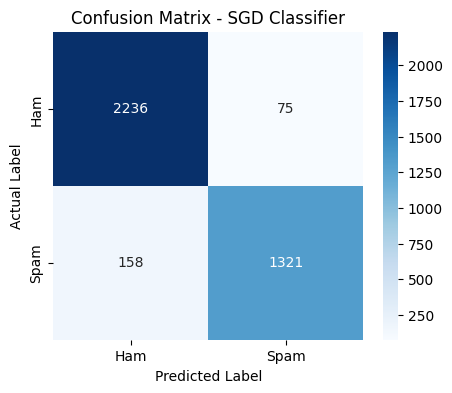

In [ ]:
# Generate Confusion Matrix for SGD Classifier
cm_sgd = confusion_matrix(y_test, y_pred_sgd)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_sgd, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - SGD Classifier")
plt.show()


In [ ]:
# Evaluate Random Forest
y_pred_rf = models["RandomForest"].predict(X_test)
report_rf = classification_report(y_test, y_pred_rf, target_names=["Ham", "Spam"])
print(f"📊 RandomForest Classification Report:\n", report_rf)


📊 RandomForest Classification Report:
               precision    recall  f1-score   support

         Ham       0.95      0.97      0.96      2311
        Spam       0.96      0.92      0.94      1479

    accuracy                           0.95      3790
   macro avg       0.95      0.95      0.95      3790
weighted avg       0.95      0.95      0.95      3790



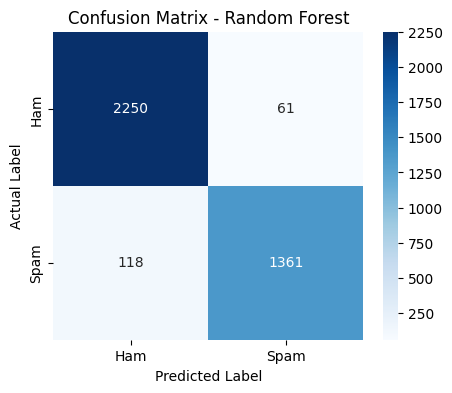

In [ ]:
# Generate Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [ ]:
# Evaluate Linear SVC
y_pred_svc = models["LinearSVC"].predict(X_test)
report_svc = classification_report(y_test, y_pred_svc, target_names=["Ham", "Spam"])
print(f"📊 LinearSVC Classification Report:\n", report_svc)


📊 LinearSVC Classification Report:
               precision    recall  f1-score   support

         Ham       0.94      0.96      0.95      2311
        Spam       0.94      0.91      0.92      1479

    accuracy                           0.94      3790
   macro avg       0.94      0.94      0.94      3790
weighted avg       0.94      0.94      0.94      3790



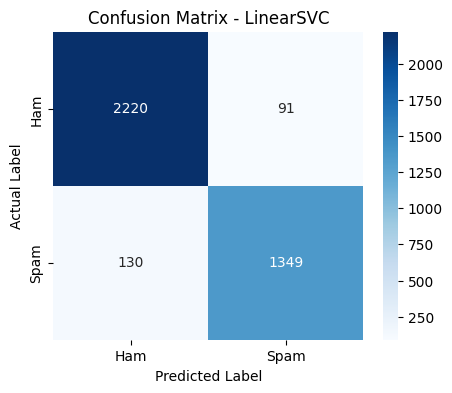

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrix
cm_svc = confusion_matrix(y_test, y_pred_svc)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - LinearSVC")
plt.show()


In [ ]:
# Evaluate Stacking Classifier
y_pred_stack = stacking_clf.predict(X_test)
report_stack = classification_report(y_test, y_pred_stack, target_names=["Ham", "Spam"])
print(f"🚀 Stacking Classifier Classification Report:\n", report_stack)


🚀 Stacking Classifier Classification Report:
               precision    recall  f1-score   support

         Ham       0.95      0.98      0.96      2311
        Spam       0.96      0.91      0.94      1479

    accuracy                           0.95      3790
   macro avg       0.95      0.94      0.95      3790
weighted avg       0.95      0.95      0.95      3790



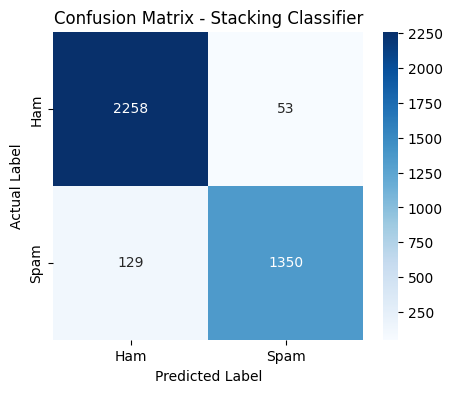

In [ ]:
# Generate Confusion Matrix for Stacking Classifier
cm_stack = confusion_matrix(y_test, y_pred_stack)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Stacking Classifier")
plt.show()


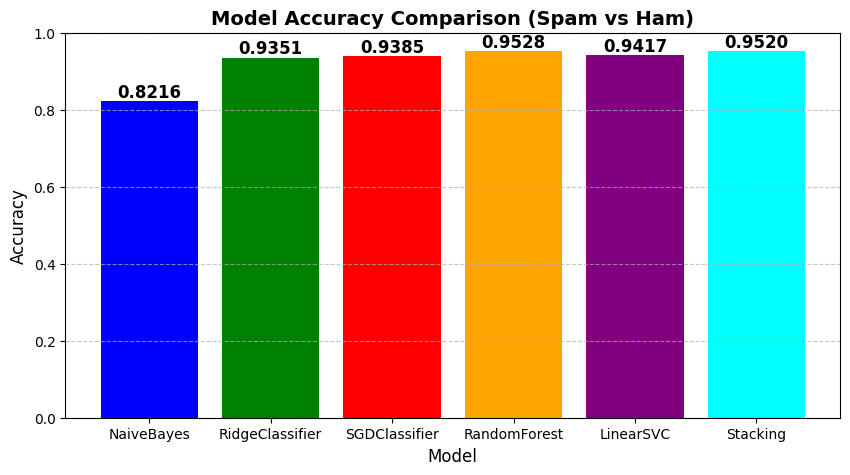

In [ ]:
import matplotlib.pyplot as plt

# Plot model comparison
plt.figure(figsize=(10,5))
bars = plt.bar(model_scores.keys(), model_scores.values(), color=["blue", "green", "red", "orange", "purple", "cyan"])

# Add accuracy score labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.4f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize plot
plt.title("Model Accuracy Comparison (Spam vs Ham)", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


In [ ]:
import re
from bs4 import BeautifulSoup

# Function to clean obfuscation from email text
def clean_text(text):
    # Remove special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Remove numbers inside words (e.g., "Fr33" → "Free")
    text = re.sub(r"\b\w*\d\w*\b", "", text)

    # Remove white font hidden text
    soup = BeautifulSoup(text, "html.parser")
    for tag in soup.find_all(style=re.compile("color:\s*white", re.IGNORECASE)):
        tag.decompose()

    return soup.get_text()

# Function to classify a custom email and check if it's from Enron, while detecting obfuscation
def classify_custom_email(email_text, sender_email):
    # Detect if email contains obfuscation
    obfuscation_detected = detect_obfuscation(email_text)

    # Clean obfuscation from text
    cleaned_email_text = clean_text(email_text)

    # Convert input text into numerical features using the same TF-IDF vectorizer
    email_features = vectorizer.transform([cleaned_email_text])

    # Get predictions from all models in stacking
    model_predictions = {name: model.predict(email_features)[0] for name, model in models.items()}
    predicted_label = label_encoder.inverse_transform([stacking_clf.predict(email_features)[0]])[0]

    # Get model influence scores (how much each model contributes)
    stacking_weights = stacking_clf.final_estimator_.coef_ if hasattr(stacking_clf.final_estimator_, "coef_") else None

    # Check if sender is from Enron
    enron_status = "✅ Email is from an Enron employee." if sender_email.endswith("@enron.com") \
                   else "⚠️ ALERT: This email is NOT from an Enron employee."

    # Display results
    print("\n📩 **Custom Email Classification**")
    print(f"🔹 **Sender:** {sender_email}")
    print(f"🔹 **Input Text (Cleaned):** {cleaned_email_text[:500]}...")  # Show first 500 characters
    print(f"🔹 **Predicted Label:** {predicted_label}")
    print(f"🔹 {enron_status}")
    print(f"🔹 **Obfuscation Detected:** {'✅ Yes' if obfuscation_detected else '❌ No'}")

    # Show model contributions if available
    if stacking_weights is not None:
        print("\n📊 **Model Contributions in Stacking Classifier:**")
        for i, (model_name, weight) in enumerate(zip(models.keys(), stacking_weights[0])):
            print(f"🔹 {model_name}: {weight:.4f}")



In [ ]:
# New Sample emails for testing with diverse content
sample_emails = [

    {
        "sender": "alice.smith@enron.com",
        "text": "Reminder: The quarterly business strategy meeting is scheduled for Monday at 2 PM. Please review the agenda before attending."
    },

    {
        "sender": "finance@quickloan.com",
        "text": "Congratulations! You are pre-approved for a $5000 loan at 0% interest. No credit check required. Apply now!"
    },

    {
        "sender": "hr@enron.com",
        "text": "Please complete your annual employee benefits enrollment by Friday. Contact HR for assistance if you have any questions."
    },

    {
        "sender": "alerts@banksecure.com",
        "text": "⚠ Urgent! Suspicious login detected. Click below to verify your account and avoid suspension."
    },

    {
        "sender": "investment@profitnow.com",
        "text": "Exclusive investment opportunity! Earn 300% ROI risk-free. Secure your spot today!"
    },

    {
        "sender": "david.jones@enron.com",
        "text": "Hey team, great job on the Q3 sales report. Let's aim for even better numbers next quarter!"
    },

    {
        "sender": "security@paypal.com",
        "text": "We have detected unauthorized access to your PayPal account. Please click the link here to prevent account suspension."
    },

    {
        "sender": "john.miller@enron.com",
        "text": "Can someone help me with the financial report for Q3? I need to finalize the numbers before the end of the week."
    },

    {
        "sender": "winner@lotteryclaim.com",
        "text": "Congratulations! You have won $1,000,000 in the International Lottery! Click here to claim your prize."
    },

    {
        "sender": "conference@enron.com",
        "text": "Reminder: Our annual corporate strategy conference will be held next Thursday. Register now to attend."
    }
]

# Test classification on sample emails
for email in sample_emails:
    classify_custom_email(email["text"], email["sender"])
    print("\n" + "="*60 + "\n")  # Separator for readability



📩 **Custom Email Classification**
🔹 **Sender:** alice.smith@enron.com
🔹 **Input Text (Cleaned):** Reminder The quarterly business strategy meeting is scheduled for Monday at  PM Please review the agenda before attending...
🔹 **Predicted Label:** Ham
🔹 ✅ Email is from an Enron employee.
🔹 **Obfuscation Detected:** ✅ Yes



📩 **Custom Email Classification**
🔹 **Sender:** finance@quickloan.com
🔹 **Input Text (Cleaned):** Congratulations You are preapproved for a  loan at  interest No credit check required Apply now...
🔹 **Predicted Label:** Ham
🔹 ⚠️ ALERT: This email is NOT from an Enron employee.
🔹 **Obfuscation Detected:** ✅ Yes



📩 **Custom Email Classification**
🔹 **Sender:** hr@enron.com
🔹 **Input Text (Cleaned):** Please complete your annual employee benefits enrollment by Friday Contact HR for assistance if you have any questions...
🔹 **Predicted Label:** Ham
🔹 ✅ Email is from an Enron employee.
🔹 **Obfuscation Detected:** ✅ Yes



📩 **Custom Email Classification**
🔹 **Sender:** 

In [ ]:
pip install --upgrade scikit-learn==1.6.1

In [ ]:
import joblib
import os

# 📌 Step 1: Define the Directory to Save Models
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# 📌 Step 2: Save the Latest TF-IDF Vectorizer
vectorizer_path = os.path.join(save_dir, "tfidf_vectorizer.pkl")
joblib.dump(vectorizer, vectorizer_path)
print(f"✅ TF-IDF Vectorizer updated at: {vectorizer_path}")

# 📌 Step 3: Save the Latest Stacking Classifier Model
model_path = os.path.join(save_dir, "stacking_classifier.pkl")
joblib.dump(stacking_clf, model_path)
print(f"✅ Stacking Classifier Model updated at: {model_path}")

# 📌 Step 4: Save the Latest Label Encoder
label_encoder_path = os.path.join(save_dir, "label_encoder.pkl")
joblib.dump(label_encoder, label_encoder_path)
print(f"✅ Label Encoder updated at: {label_encoder_path}")

# 📌 Step 5: Save the Latest Dataset with Predictions
dataset_path = os.path.join(save_dir, "classified_emails.csv")
df.to_csv(dataset_path, index=False)
print(f"✅ Classified dataset updated at: {dataset_path}")

# 📌 Step 6: Confirm Updated Files
print("\n📦 **Updated Files for Website Integration:**")
print(f"📂 TF-IDF Vectorizer: {vectorizer_path}")
print(f"📂 Stacking Classifier Model: {model_path}")
print(f"📂 Label Encoder: {label_encoder_path}")
print(f"📂 Classified Dataset: {dataset_path}")


✅ TF-IDF Vectorizer updated at: saved_models/tfidf_vectorizer.pkl
✅ Stacking Classifier Model updated at: saved_models/stacking_classifier.pkl
✅ Label Encoder updated at: saved_models/label_encoder.pkl
✅ Classified dataset updated at: saved_models/classified_emails.csv

📦 **Updated Files for Website Integration:**
📂 TF-IDF Vectorizer: saved_models/tfidf_vectorizer.pkl
📂 Stacking Classifier Model: saved_models/stacking_classifier.pkl
📂 Label Encoder: saved_models/label_encoder.pkl
📂 Classified Dataset: saved_models/classified_emails.csv
